<a href="https://colab.research.google.com/github/aliabdollahy/PCA2S/blob/master/PCA2S_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/My Drive/

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive


***********
(144000, 2)
index
2    0.427165
3    0.455791
4    0.451316
5    0.467507
6    0.474021
Name: load, dtype: float64
Train for 200 steps, validate for 800 steps
Epoch 1/3
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
200/200 [==============================] - 771s 4s/step - loss: 0.1100 - val_loss: 0.0626
Epoch 2/3
200/200 [==============================] - 770s 4s/step - loss: 0.0675 - val_loss: 0.0635
Epoch 3/3
200/200 [==============================] - 753s 4s/step - loss: 0.0665 - val_loss: 0.0621
(256, 400, 1) (256,)
(256, 1)
(256,)


No handles with labels found to put in legend.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
No handles with labels found to put in legend.


(256,)


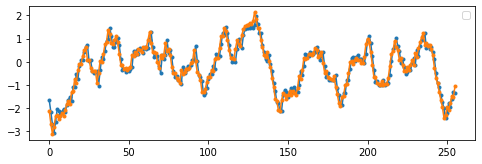

(256, 400, 1) (256,)
(256, 1)
(256,)


No handles with labels found to put in legend.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
No handles with labels found to put in legend.


(256,)


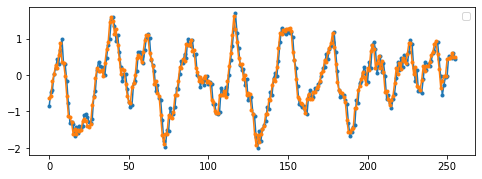

(256, 400, 1) (256,)
(256, 1)
(256,)


No handles with labels found to put in legend.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
No handles with labels found to put in legend.


(256,)


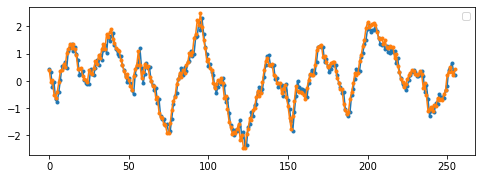

In [0]:

from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf

tf.enable_eager_execution()

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from tensorflow.keras.optimizers import Adam

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

df = pd.read_excel("dataset.xlsx")
df.columns = ['index', 'load']
print("***********")
print(df.shape)





def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []
  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)



TRAIN_SPLIT = 140000

uni_data = df['load']
uni_data.index = df['index']
print(uni_data.head())
print(uni_data.plot(subplots=True))
uni_data = uni_data.values

uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()
uni_data = (uni_data-uni_train_mean)/uni_train_std

univariate_past_history = 400
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)



def create_time_steps(length):
  time_steps = []
  for i in range(-length, 0, 1):
    time_steps.append(i)
  return time_steps


def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

def baseline(history):
  return np.mean(history)
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
           'Baseline Prediction Example')

BATCH_SIZE = 256
BUFFER_SIZE = 1000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()


simple_lstm_model = tf.keras.models.Sequential()
simple_lstm_model.add(tf.keras.layers.LSTM(50, 
                                           input_shape=x_train_uni.shape[-2:], 
                                           return_sequences=True,))
simple_lstm_model.add(tf.keras.layers.LSTM(50, 
                                           return_sequences=True))
simple_lstm_model.add(tf.keras.layers.LSTM(50))
simple_lstm_model.add(tf.keras.layers.Dense(1))


#simple_lstm_model = tf.keras.models.Sequential([
#    tf.keras.layers.LSTM(256, input_shape=x_train_uni.shape[-2:]),
#    tf.keras.layers.Activation('relu'),
#    tf.keras.layers.Dense(1),
#
#])

def cal_flat_Shape(shape):
    flat_shap = 1
    for dim in shape:
        flat_shap *= dim
    return flat_shap

EPOCHS = 3
EVALUATION_INTERVAL = 200
lstm_model.compile(loss='mean_squared_error', 
                          optimizer=Adam(lr=0.01))
lstm_model.fit(train_univariate, 
                      epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, 
                      validation_steps=43200)


for x, y in val_univariate.take(3):
  #plot = show_plot([x[0].numpy(), y[0].numpy(),
  #                  simple_lstm_model.predict(x)], 0, 'Simple LSTM model')
  #plot.show()
  print(x.shape, y.shape)
  print(simple_lstm_model.predict(x).shape)
  print(simple_lstm_model.predict(x).flatten().shape)
  
  y1 = simple_lstm_model.predict(x).flatten()
  y2 = y.numpy().flatten()
  print(y2.shape)
  

  
  x1 = [i for i in range(len(y2))]
  x2 = [i for i in range(len(y2))]

  plt.subplot(2, 1, 1)
  plt.plot(x1, y1, '.-')
  plt.legend()
  plt.subplot(2, 1, 1)
  plt.plot(x2, y2, '.-')
  plt.legend()
  plt.show()




In [0]:
import itertools
tf.compat.v1.enable_eager_execution()

def gen():
  for i in itertools.count(1):
    yield (i, [1] * i)

ds = tf.data.Dataset.from_generator(
    gen, (tf.int64, tf.int64), (tf.TensorShape([]), tf.TensorShape([None])))

for value in ds.take(2):
  print (value)
a = [1,2,3]
a = sum(a)/len(a)
print(a)

(<tf.Tensor: id=6900, shape=(), dtype=int64, numpy=1>, <tf.Tensor: id=6901, shape=(1,), dtype=int64, numpy=array([1])>)
(<tf.Tensor: id=6902, shape=(), dtype=int64, numpy=2>, <tf.Tensor: id=6903, shape=(2,), dtype=int64, numpy=array([1, 1])>)
2.0
